<a href="https://colab.research.google.com/github/Hyorim-Kim/colab/blob/main/tfc33stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LSTM + Dense 모델을 작성해 주가 예측
# 삼성전자 증권표준코드 005930
!pip install finance-datareader

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import warnings
warnings.filterwarnings('ignore')

STOCK_CODE = '005930'
stock_data = fdr.DataReader(STOCK_CODE)
print(stock_data.head(3))
print(stock_data.tail(3))

print('상관관계 : ', stock_data.corr(method='pearson'))
stock_data.reset_index(inplace=True)
print(stock_data.head(3))
stock_data.drop(['Change'], axis='columns', inplace=True)
print(stock_data.head(3))
print(stock_data.info())


            Open  High   Low  Close  Volume    Change
Date                                                 
1999-08-20  3560  3560  3460   3520  529333       NaN
1999-08-23  3590  3740  3560   3700  674482  0.051136
1999-08-24  3800  3879  3730   3850  794226  0.040541
             Open   High    Low  Close    Volume    Change
Date                                                      
2023-12-05  72300  72400  71200  71200  12129682 -0.019284
2023-12-06  71800  72100  71600  71700   8123087  0.007022
2023-12-07  71800  71800  71300  71500   3184065 -0.002789
상관관계 :              Open      High       Low     Close    Volume    Change
Open    1.000000  0.999885  0.999914  0.998298  0.743094 -0.012340
High    0.999885  1.000000  0.999882  0.998421  0.745907 -0.006971
Low     0.999914  0.999882  1.000000  0.998422  0.741330 -0.007744
Close   0.998298  0.998421  0.998422  1.000000  0.742772 -0.001516
Volume  0.743094  0.745907  0.741330  0.742772  1.000000  0.003026
Change -0.012340 -0.00697

        Date  Open  High   Low  Close  Volume  year  month  day
0 1999-08-20  3560  3560  3460   3520  529333  1999      8   20
1 1999-08-23  3590  3740  3560   3700  674482  1999      8   23
2 1999-08-24  3800  3879  3730   3850  794226  1999      8   24
(6000, 9)


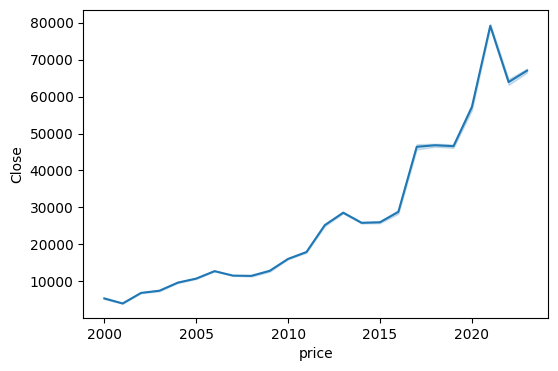

In [ ]:
# Date열을 이용해 연도별 주가 변동 시각화
# Date열을 연,월,일로 분리해 새로운 열을 추가
stock_data['year'] = stock_data['Date'].dt.year
stock_data['month'] = stock_data['Date'].dt.month
stock_data['day'] = stock_data['Date'].dt.day
print(stock_data.head(3))
print(stock_data.shape)  # (6000, 9)

df = stock_data.loc[stock_data['year'] >= 2000]
plt.figure(figsize=(6, 4))
sns.lineplot(y=df['Close'], x=df.year)
plt.xlabel('time')
plt.xlabel('price')
plt.show()


In [ ]:
# 전처리 계속 : Open  High   Low  Close  Volume
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(stock_data[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
print(df_scaled.head(3))

col_close = ['Close']
close_scaled = scaler.fit_transform(stock_data[col_close])
print('스케일 값 : ', close_scaled[:5].ravel())
print('스케일 원복 값 : ', scaler.inverse_transform(close_scaled[:5]).ravel())

# 과거 20일을 기준으로 그 다음날의 종가를 예측. 전체 데이터는 과거 200일, 예측 기준은 과거 20일 사용
TEST_SIZE = 200
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]
print(train.shape)  # (5800, 5)
print(test.shape)   # (200, 5)

# dataset 작성 함수
def make_dataset_func(data, label, window_size=20):
  feature_list = []
  label_list = []
  for i in range(len(data) - window_size):
    feature_list.append(np.array(data.iloc[i:i+window_size]))
    label_list.append(np.array(label.iloc[i+window_size]))
  return np.array(feature_list), np.array(label_list)  # 순차적으로 20일 동안의 data를 묶어, 대응하는 label과 함께 반환

feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]
print(train_feature[:3])
print(train_label[:3])
print(train_feature.shape, train_label.shape, test_feature.shape, test_label.shape)  # (5800, 4) (5800, 1) (200, 4) (200, 1)

train_feature, train_label = make_dataset_func(train_feature, train_label)
print(train_feature[:2], train_label[:2])

# train_test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_feature, train_label, test_size=0.2, random_state=12, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)  # (4624, 20, 4) (1156, 20, 4) (4624, 1) (1156, 1)

# test
test_feature, test_label = make_dataset_func(test_feature, test_label)
print(test_feature[:2], test_label[:2])
print(test_feature.shape, test_label.shape)  # (180, 20, 4) (180, 1)


       Open      High       Low     Close    Volume
0  0.039424  0.036777  0.038659  0.008950  0.005862
1  0.039756  0.038636  0.039777  0.010989  0.007469
2  0.042082  0.040072  0.041676  0.012688  0.008795
스케일 값 :  [0.00894981 0.01098901 0.01268834 0.01427439 0.0171066 ]
스케일 원복 값 :  [3520. 3700. 3850. 3990. 4240.]
(5800, 5)
(200, 5)
       Open      High       Low    Volume
0  0.039424  0.036777  0.038659  0.005862
1  0.039756  0.038636  0.039777  0.007469
2  0.042082  0.040072  0.041676  0.008795
      Close
0  0.008950
1  0.010989
2  0.012688
(5800, 4) (5800, 1) (200, 4) (200, 1)
[[[0.03942414 0.03677686 0.03865922 0.00586154]
  [0.03975637 0.03863636 0.03977654 0.00746884]
  [0.04208195 0.04007231 0.04167598 0.00879481]
  [0.04263566 0.04183884 0.04301676 0.01247929]
  [0.04473976 0.04493802 0.04435754 0.01583163]
  [0.04761905 0.0481405  0.04715084 0.01438247]
  [0.05005537 0.04772727 0.04849162 0.00973498]
  [0.04717608 0.0463843  0.04759777 0.01202602]
  [0.05094131 0.04834711 

In [ ]:
# model
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(units=16, activation='tanh', input_shape=(train_feature.shape[1], train_feature.shape[2]), return_sequences=False))  # many-to-one
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1344      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1633 (6.38 KB)
Trainable params: 1633 (6.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
from keras.losses import Huber
model.compile(optimizer='adam', loss=Huber(), metrics=['mse'])
# Huber loss는 모든 지점에서 미분이 가능하면서 이상치에 강건한(robust) 성격을 보인다.

es = EarlyStopping(monitor='val_loss', patience=10)
chkPoint = ModelCheckpoint('tfc33.hdf5', monitor='val_loss', save_best_only=True, mode='auto', verbose=0)
history = model.fit(x_train, y_train, epochs=100, batch_size=8, validation_data=(x_test, y_test), verbose=2, callbacks=[es, chkPoint])


Epoch 1/100
578/578 - 7s - loss: 5.4559e-05 - mse: 1.0912e-04 - val_loss: 0.0054 - val_mse: 0.0108 - 7s/epoch - 12ms/step
Epoch 2/100
578/578 - 4s - loss: 5.0514e-05 - mse: 1.0103e-04 - val_loss: 0.0043 - val_mse: 0.0086 - 4s/epoch - 7ms/step
Epoch 3/100
578/578 - 3s - loss: 5.4721e-05 - mse: 1.0944e-04 - val_loss: 0.0055 - val_mse: 0.0109 - 3s/epoch - 6ms/step
Epoch 4/100
578/578 - 3s - loss: 5.2306e-05 - mse: 1.0461e-04 - val_loss: 0.0047 - val_mse: 0.0094 - 3s/epoch - 5ms/step
Epoch 5/100
578/578 - 3s - loss: 4.7734e-05 - mse: 9.5469e-05 - val_loss: 0.0052 - val_mse: 0.0103 - 3s/epoch - 5ms/step
Epoch 6/100
578/578 - 4s - loss: 4.6417e-05 - mse: 9.2835e-05 - val_loss: 0.0055 - val_mse: 0.0109 - 4s/epoch - 7ms/step
Epoch 7/100
578/578 - 3s - loss: 4.2903e-05 - mse: 8.5805e-05 - val_loss: 0.0054 - val_mse: 0.0108 - 3s/epoch - 5ms/step
Epoch 8/100
578/578 - 3s - loss: 4.0536e-05 - mse: 8.1072e-05 - val_loss: 0.0037 - val_mse: 0.0074 - 3s/epoch - 6ms/step
Epoch 9/100
578/578 - 3s - loss

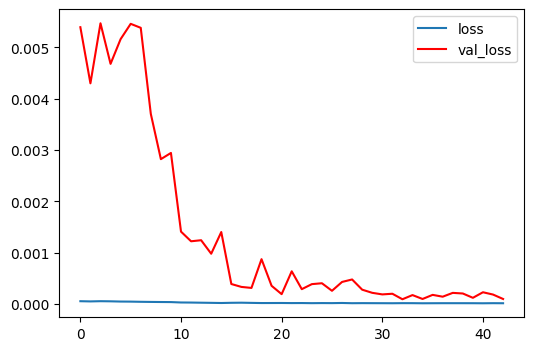

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', c='red')
plt.legend()
plt.show()


r2_score :  0.8925883330788438
pred :  [0.64 0.66 0.66 0.66 0.66 0.66 0.68 0.68 0.68 0.68]
real :  [0.66 0.65 0.65 0.66 0.67 0.68 0.67 0.68 0.68 0.69]
pred :  [59627.76  61060.93  60944.086 60596.13  61120.918 61186.992 62774.78
 62528.207 62488.438 62564.637]
real :  [61300. 60200. 60300. 61100. 62300. 63000. 62100. 62900. 62700. 63200.]


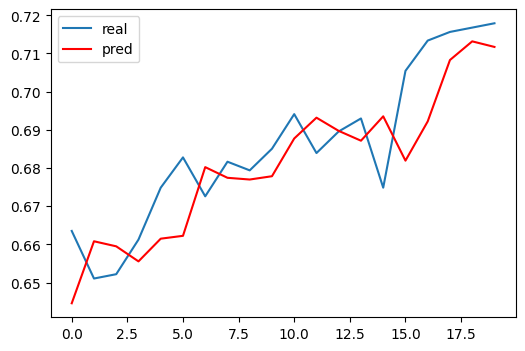

In [ ]:
import keras
model = keras.models.load_model('tfc33.hdf5')

pred = model.predict(test_feature, verbose=0)

from sklearn.metrics import r2_score
print('r2_score : ', r2_score(test_label, pred))

print('pred : ', np.round(pred[:10].flatten(), 2))
print('real : ', np.round(test_label[:10].flatten(), 2))
print('pred : ', scaler.inverse_transform(pred[:10]).flatten())
print('real : ', scaler.inverse_transform(test_label[:10]).flatten())

# 실제값, 예측값 시각화
plt.figure(figsize=(6, 4))
plt.plot(test_label[:20], label='real')
plt.plot(pred[:20].flatten(), label='pred', c='red')
plt.legend()
plt.show()
